In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import gamma

# forcing nano scale
from matplotlib.ticker import ScalarFormatter
nano_formatter = ScalarFormatter(useMathText=True)
nano_formatter.set_powerlimits((-9, -9))  # Force e-9

# manually plotting prediction rings
from matplotlib.patches import Circle

# TrackPy stuff
import trackpy as tp
import pims

import cv2

def nano(num):
    return num * 10**(-9)

# Brownian motion equations:

**note:** This notebook works in meters and does not consider pixel size

Movement changes in different directions:
$$\Delta x_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
$$\Delta y_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
$$\Delta z_i \sim N(0, sd = \sqrt{2 \cdot D_i \cdot \Delta t}) $$
 - $\Delta t$ = time step
 - D = diffusion coefficient

How that relates to mean squared displacement: from crocker grier:
$$ (|r(t + \tau) - r(t)|^2) = 2 \cdot d \cdot D \cdot \tau$$
 - d = number of dimensions
 - $\tau$ = time interval
 - D = diffusion coefficient

Diffusion coefficient equation:
$$D_i = \frac{k_B T}{6 \pi \eta r_i} $$
- $D_i$ = diffusion coefficient
- $k_B$ = Bolzman's constant ($1.380649 × 10^{-23}$)
- $T$ = temperature (Kelvin)
- $\eta$ = dynamic viscosity
- $r_i$ = particle radius





# 2d simulation case

#### previous student's stokes-einstein code

(modified to return D instead of sigma)

In [2]:
def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)
    
    return D

#### Code to run simulation

In [3]:
# from test data
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

num_particles = 10
num_frames = 100

# generate particle radiuses
radii = np.linspace(nano(50), nano(150), num_particles)
#radii = np.random.normal(nano(100), nano(10), num_particles)

# generate diffusion coefficients
Ds = stokes_einstein(radii, t, T_Kelvin, eta)
# calculate sigmas
variance = 2 * Ds * t
sigmas = np.sqrt(variance)

# create initial positions
positions = np.zeros((num_frames, num_particles, 2))
# have all particles start at origin for now


# do wiener step process
for frame in range(1, num_frames):
    # from previous group:
    move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                 np.random.normal(0, sigmas, num_particles)))
    positions[frame] = positions[frame - 1] + move

    

#### Code to plot simulation

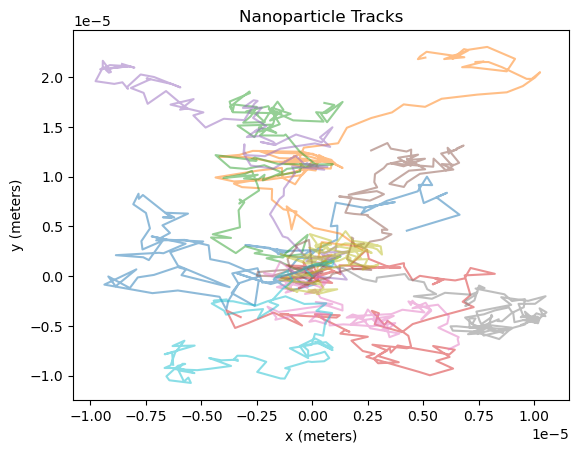

In [4]:
def plot_2d_particles(positions, particle_inds="all", alpha=0.5):
    num_particles = positions.shape[1]
    
    if particle_inds == "all":
        for i in range(num_particles):
            plt.plot(positions[:, i, 0], positions[:, i, 1], alpha=alpha)
        
        plt.xlabel("x (meters)")
        plt.ylabel("y (meters)")
        plt.title("Nanoparticle Tracks")
        
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        for i in particle_inds:
            plt.plot(positions[:, i, 0], positions[:, i, 1], alpha=alpha)
        
        plt.xlabel("x (meters)")
        plt.ylabel("y (meters)")
        plt.title("Nanoparticle Tracks (filtered)")
        
        plt.show()
        

#plot_2d_particles(positions, particle_inds=[0], alpha=1)
plot_2d_particles(positions)

# 2d Bayesian postierior equation case

In Bayesian statistics, the likelihood function is defined as $L(param | data) = P(data | param)$

We can use our known equations of $\Delta x_i \sim N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$ and 
$\Delta y_i \sim N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$ to create a likelihood for $r_i$

$$ $$

Since $\Delta x_i$ and $\Delta y_i$ are iid, we will treat them as observations from the same distribution, which gives use twice the sample size.



$$ $$

Now let use define the precision as $\tau = \frac{1}{\sigma^2}$. If we attempt to solve this by estimating the precision $\tau$, we can treat this as a Bayesian problem of a normal distribution with known precision. This gives us the following Bayesian equations: ($\Gamma$ = Gamma distribution)

$$\text{Prior}(\tau) = \Gamma(\alpha, \beta)$$
$$\text{Posterior}(\tau | x_1, x_2, \dots, x_n) = \Gamma\left(\alpha + \frac{n}{2}, \beta + \frac{\sum^n_{i=1} (x_i - \mu)^2}{2}\right) $$

Wikipedia conjugates page: https://en.wikipedia.org/wiki/Conjugate_prior

$$ $$

For our case, we can treat all parameters other than radius as constant, which gives us the variance:
$$ \sigma^2 = 2 \cdot D_i \cdot \Delta t = 2 \cdot \frac{k_B T}{6 \pi \eta r_i} \cdot \Delta t = \frac{C}{r_i} \qquad \text{ where } C = \frac{k_B T \Delta t}{3 \pi \eta}$$

Likewise, this gives us the precision:
$$\tau = \frac{r_i}{C} \qquad \text{ where } C = \frac{k_B T \Delta t}{3 \pi \eta} $$


$$ $$

With this, we get out precision posterior:

$$\text{Posterior}(\frac{r_i}{C}| \Delta x_1, \Delta y_1, \Delta x_2, \Delta y_2, \dots, \Delta x_n, \Delta y_n) = \Gamma\left(\alpha + n, \beta + \frac{\sum^n_{i=1} (\Delta x_i)^2 + \sum^n_{i=1} (\Delta y_i)^2}{2}\right) $$


When can then use this property of Gamma distributions:
$$\text{if } X \sim \Gamma(\alpha, \beta), \text{then for constant } C \text{, we have: } CX \sim \Gamma\left(\alpha, \frac{\beta}{C}\right)$$

This gives us our final posterior distribution for $r_i$:
$$\text{Posterior}(r_i | \Delta x_1, \Delta y_1, \Delta x_2, \Delta y_2, \dots, \Delta x_n, \Delta y_n) = \Gamma\left(\alpha + n, \frac{1}{C} \cdot \left(\beta + \frac{\sum^n_{i=1} (\Delta x_i)^2 + \sum^n_{i=1} (\Delta y_i)^2}{2}\right)\right) $$


# code for 2d ground truth movement inference

The code fits a prior gamma distribution to our known values for $\tau$ and then calculates the posterior for each particle based on their movement in the positions array

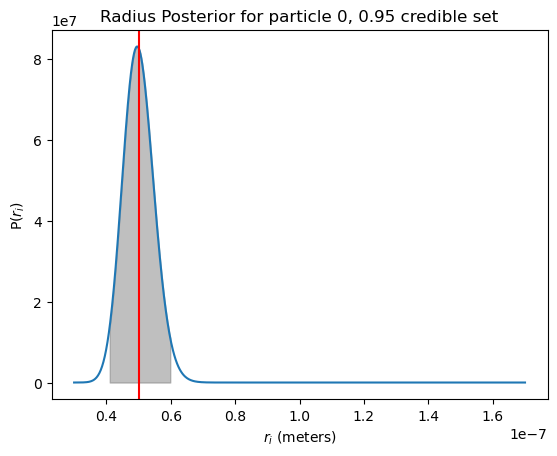

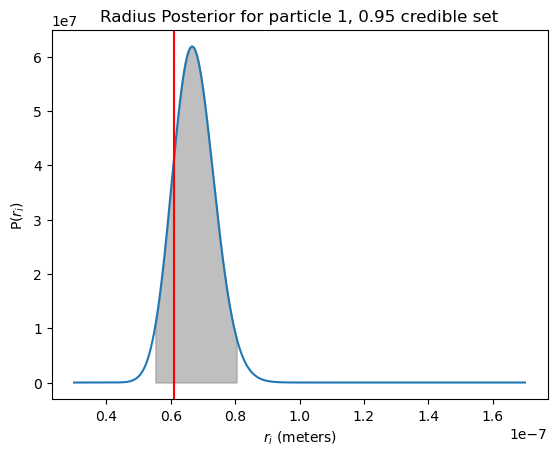

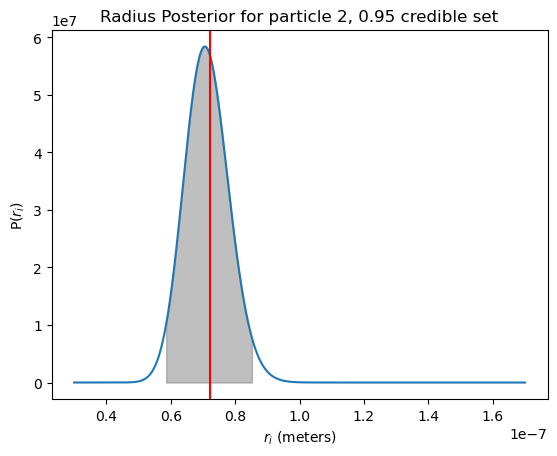

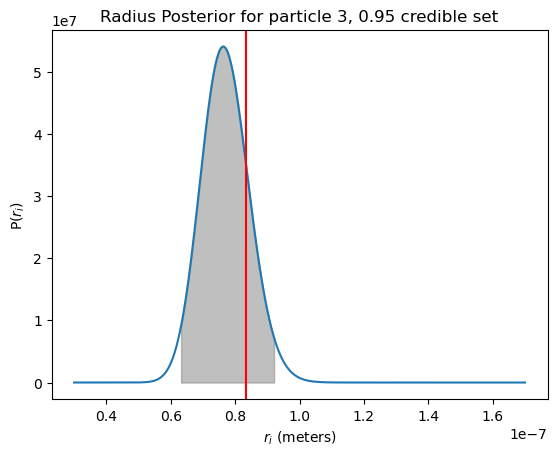

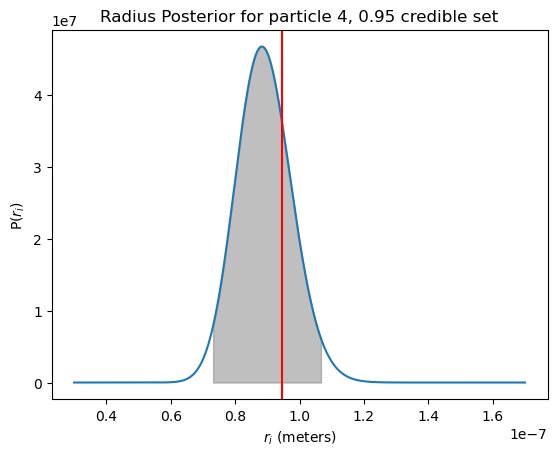

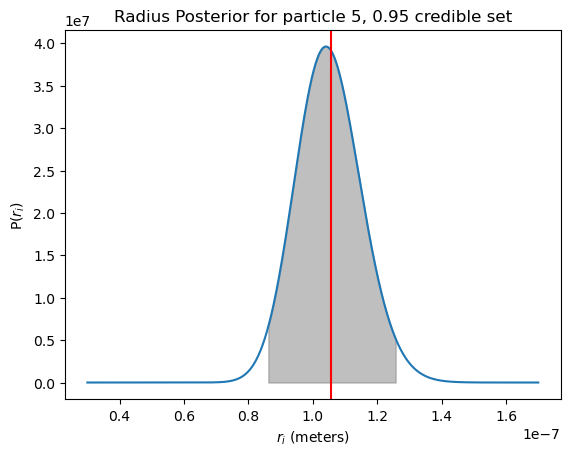

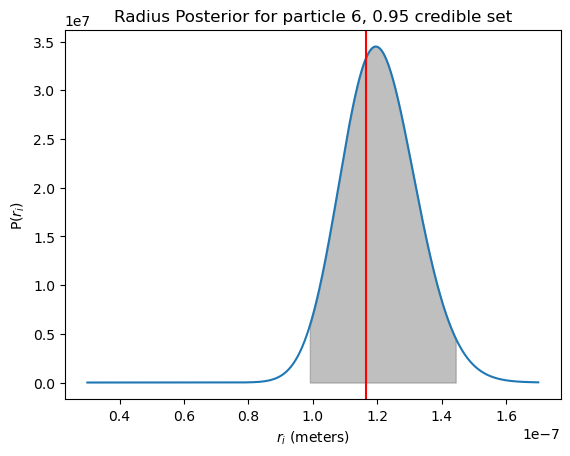

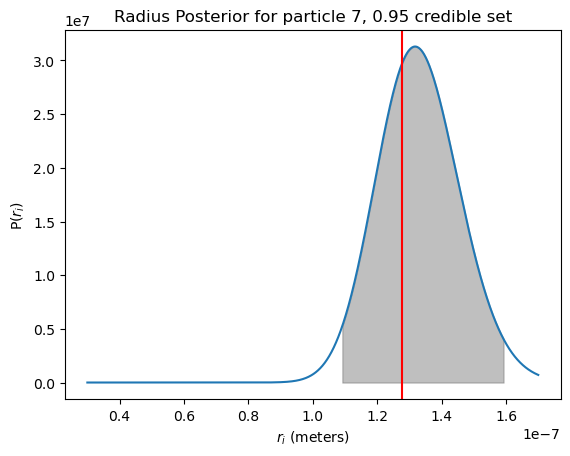

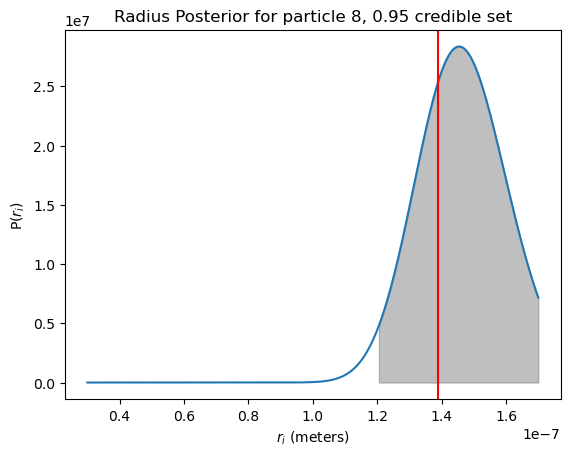

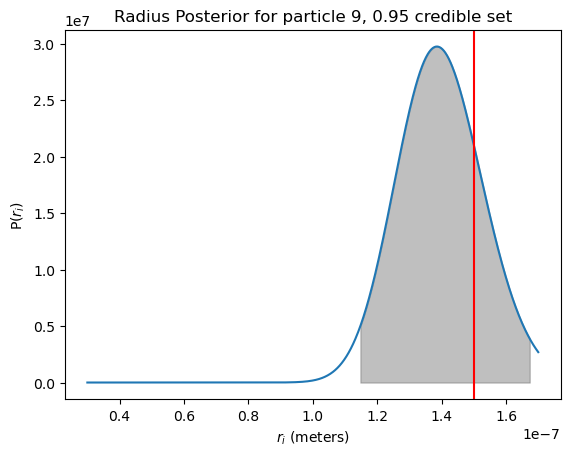

In [5]:
credible_percentage = 0.95

# calculate C
k_B = 1.38e-23

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C


# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale

#print("Prior alpha:", prior_alpha, " prior beta:", prior_beta)

# run through inference for each particle
for i in range(num_particles):
    # get x and y positions
    x_pos = positions[:, i, 0]
    y_pos = positions[:, i, 1]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    
    # get true radius
    true_radius = radii[i]


    # Plot posterior and true value

    # calculate gamma curve for posterior
    plot_x = np.linspace(nano(30), nano(170), 1000)
    plot_y = gamma.pdf(plot_x, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Plot posterior gamma curve
    plt.plot(plot_x, plot_y)
    
    # Add red line for true radius
    plt.axvline(true_radius, color='r')


    # calculate credible set
    tail = (1 - credible_percentage) / 2
    lower_bound = gamma.ppf(tail, a=posterior_alpha, scale= 1 / posterior_beta)
    upper_bound = gamma.ppf(1 - tail, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Shade credible set
    plt.fill_between(plot_x, plot_y, where=(plot_x >= lower_bound) & (plot_x <= upper_bound), color='gray', alpha=0.5)
    
    
    plt.title(f"Radius Posterior for particle {i}, {credible_percentage} credible set")
    plt.xlabel("$r_i$ (meters)")
    plt.ylabel("P($r_i$)")
    
    plt.show()



# 3d simulation case

#### Code to run simulation

Same as before but with one extra dimension now

In [6]:
# from test data
t = 0.1 # 100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

num_particles = 10
num_frames = 100

# generate particle radiuses
radii = np.linspace(nano(50), nano(150), num_particles)
#radii = np.random.normal(nano(100), nano(10), num_particles)

# generate diffusion coefficients
Ds = stokes_einstein(radii, t, T_Kelvin, eta)
# calculate sigmas
variance = 2 * Ds * t
sigmas = np.sqrt(variance)

# create initial positions
positions = np.zeros((num_frames, num_particles, 3))
# have all particles start at origin for now


# do wiener step process
for frame in range(1, num_frames):
    # from previous group:
    move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                 np.random.normal(0, sigmas, num_particles), np.random.normal(0, sigmas, num_particles)))
    positions[frame] = positions[frame - 1] + move

#### Code to plot simulation

Since this is 3d, I'm not going to worry about plotting the simulation

# 3d Bayesian postierior equation case

Since we have the ground truth of $\Delta z_i$, we can also treat it as iid with $\Delta x_i$ and $\Delta y_i$. So we will treat all x, y, and z movements as coming from the same distribution of $N(0, \sigma^2 = 2 \cdot D_i \cdot \Delta t)$, giving us three times the sample size.


Since the math should be the same, I'll skip to the final posterior equation:

If $\text{Prior}(\tau = \frac{r_i}{C}) = \Gamma(\alpha, \beta)$, then:

$$\text{Posterior}(r_i | \Delta x_1, \Delta y_1, \Delta z_1, \Delta x_2, \Delta y_2, \Delta z_2, \dots, \Delta x_n, \Delta y_n, \Delta z_n) = \Gamma\left(\alpha + 1.5 \cdot n, \frac{1}{C} \cdot \left(\beta + \frac{\sum^n_{i=1} ((\Delta x_i)^2 + (\Delta y_i)^2 + (\Delta z_i)^2)}{2}\right)\right) $$

where $C = \frac{k_B T \Delta t}{3 \pi \eta}$


#### code for 3d ground truth movement inference

The code fits a prior gamma distribution to our known values for $\tau$ and then calculates the posterior for each particle based on their movement in the positions array

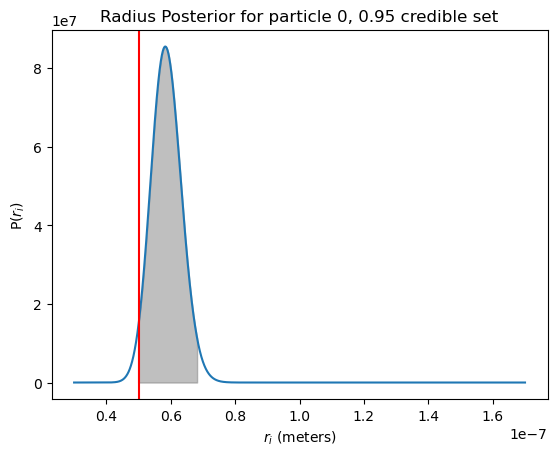

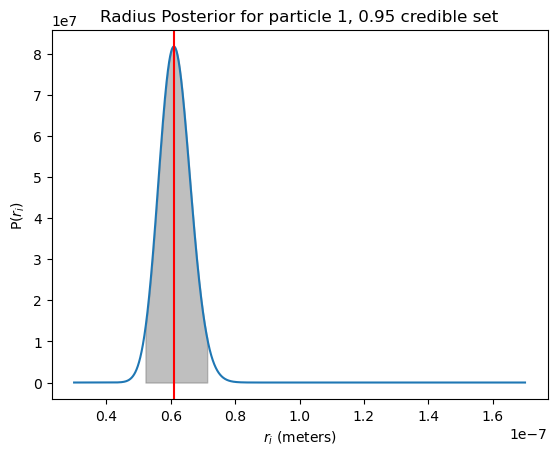

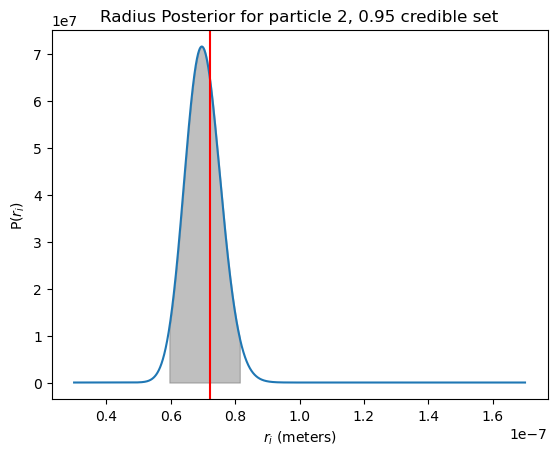

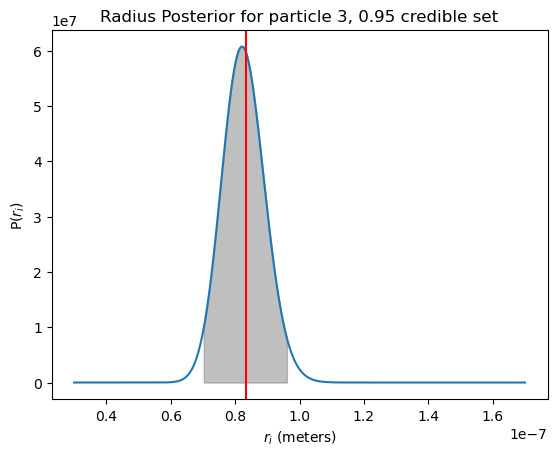

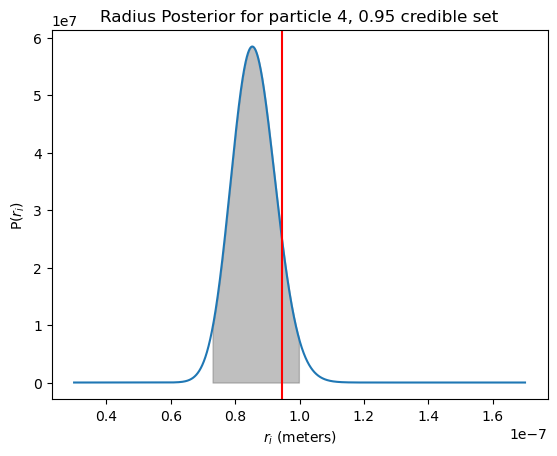

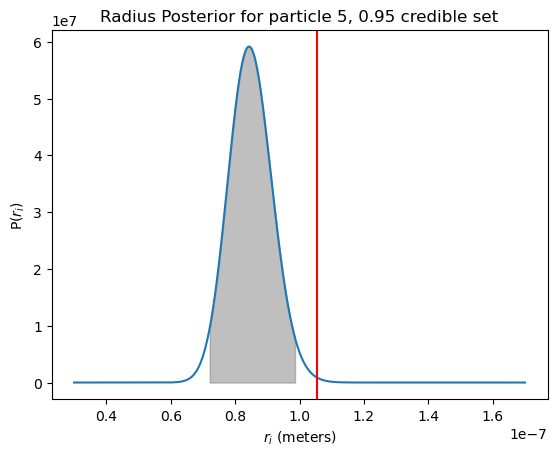

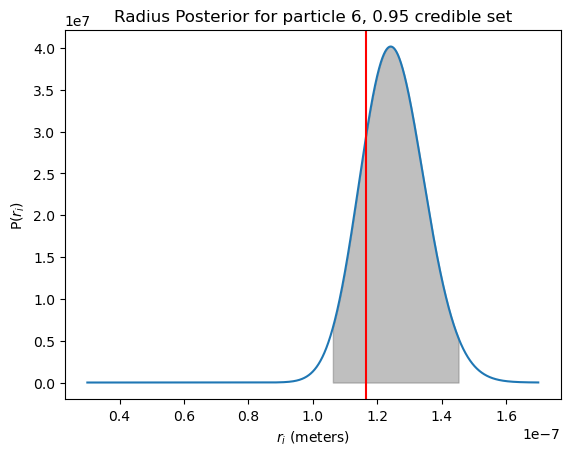

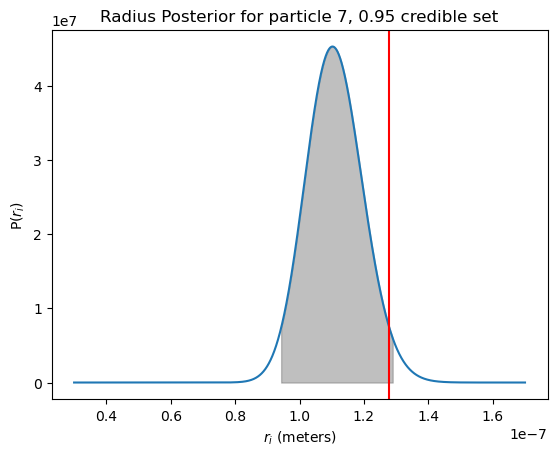

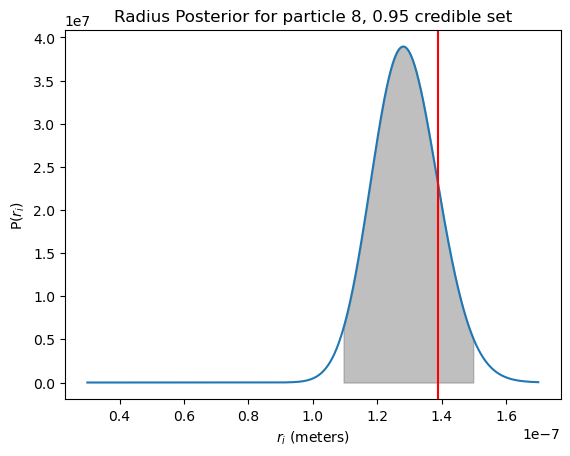

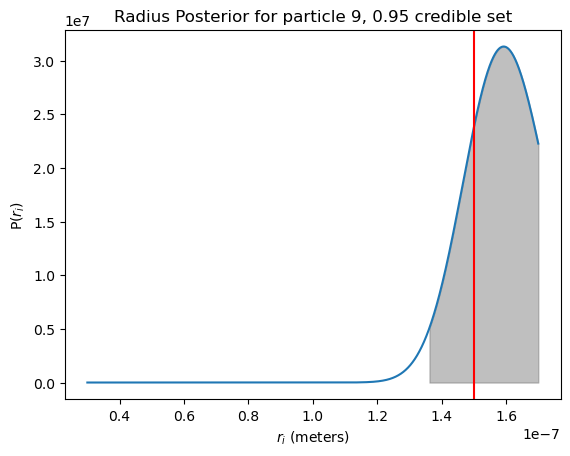

In [7]:
credible_percentage = 0.95

# calculate C
k_B = 1.38e-23

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C


# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale

#print("Prior alpha:", prior_alpha, " prior beta:", prior_beta)

# run through inference for each particle
for i in range(num_particles):
    # get x, y, and z positions
    x_pos = positions[:, i, 0]
    y_pos = positions[:, i, 1]
    z_pos = positions[:, i, 2]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)
    z_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)
    z_dist_sqd = np.square(z_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd, z_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    # get true radius
    true_radius = radii[i]


    # Plot posterior and true value

    # calculate gamma curve for posterior
    plot_x = np.linspace(nano(30), nano(170), 10000)
    plot_y = gamma.pdf(plot_x, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Plot posterior gamma curve
    plt.plot(plot_x, plot_y)
    
    # Add red line for true radius
    plt.axvline(true_radius, color='r')


    # calculate credible set
    tail = (1 - credible_percentage) / 2
    lower_bound = gamma.ppf(tail, a=posterior_alpha, scale= 1 / posterior_beta)
    upper_bound = gamma.ppf(1 - tail, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # Shade credible set
    plt.fill_between(plot_x, plot_y, where=(plot_x >= lower_bound) & (plot_x <= upper_bound), color='gray', alpha=0.5)

    
    plt.title(f"Radius Posterior for particle {i}, {credible_percentage} credible set")
    plt.xlabel("$r_i$ (meters)")
    plt.ylabel("P($r_i$)")
    
    plt.show()

Divider section

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$
$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$
$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Inference with PyMC

## 2d Model with no noise:

This model works off the distribution:
$$\Delta(x \text{ or } y) \sim N \left(0, \sigma = \frac{1}{\sqrt{\tau}} = \sqrt{\frac{C}{r_i}}\right) $$

$$\tau = \frac{r_i}{C} = \frac{1}{\sigma^2}$$

From earlier in paper:
$$\tau = \frac{r_i}{C} \qquad \text{ where } C = \frac{k_B T \Delta t}{3 \pi \eta} $$


6.111111111111111e-08


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma]


Output()

Sampling 3 chains for 10_000 tune and 20_000 draw iterations (30_000 + 60_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


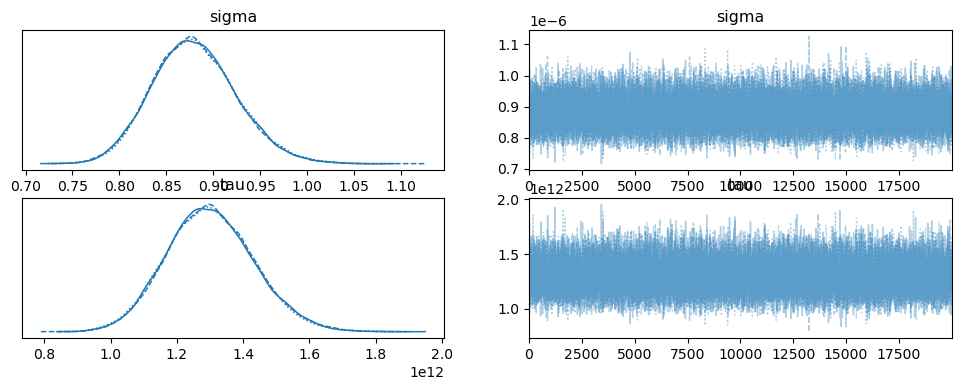

In [8]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Simulated data
# get x and y positions
index = 1
x_pos = positions[:, index, 0]
y_pos = positions[:, index, 1]

true_radius = radii[index]
print(true_radius)

# calculate movement by differences between positions
x_dist = np.diff(x_pos)
y_dist = np.diff(y_pos)

dist_arr = np.concatenate((x_dist, y_dist))


# Define model
with pm.Model() as model:
    # suggested method for MCMC non informative prior
    sigma = pm.HalfCauchy("sigma", beta=5)
    tau = pm.Deterministic("tau", 1 / sigma**2)
    
    obs = pm.Normal("obs", mu=0, sigma=sigma, observed=dist_arr)
    
    # Use NUTS sampler
    trace = pm.sample(draws=20000, tune=10000, chains=3, target_accept=0.9, return_inferencedata=True)

# Summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

##### Multiply tau by C to get r

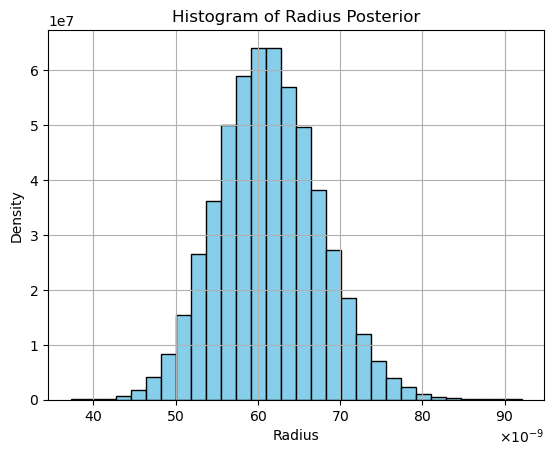

In [9]:
import matplotlib.pyplot as plt
import arviz as az

# Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()

# Multiply by C to get r
scaled_tau = tau_samples * C

# Plot histogram
plt.hist(scaled_tau, bins=30, density=True, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radius Posterior")
plt.grid(True)
plt.show()

In [10]:
np.mean(scaled_tau > true_radius)

np.float64(0.5064666666666666)

$$ $$

$$ $$

$$ $$

# Can we incorporate location estimation errors?

Adding noise to the observed $\Delta x$ and $\Delta y$, we can say:

$$\Delta \tilde{x} = \Delta x + \epsilon \qquad \text{where} \qquad \epsilon \sim N(0, \sigma_0)$$

This gives a distribution:

$$\Delta \tilde{x} \sim N \left(0, \sigma = \frac{1}{\sqrt{\tau}} = \sqrt{\frac{C}{r_i}}\right) + N(0, \sigma_0)$$

Since this is the sum of two normal distributions:

$$\Delta \tilde{x} \sim N (0, \sigma + \sigma_0)$$

**note:** assumes independent normal noise

$$ $$

This shows that no matter what, our estimation error (assuming it's normal) is just going to sum into our main inference function.

However, we could maybe try to define a posterior for the extra sigma based on the location identifications from the image


6.111111111111111e-08


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, sigma_0]


Output()

Sampling 3 chains for 10_000 tune and 20_000 draw iterations (30_000 + 60_000 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


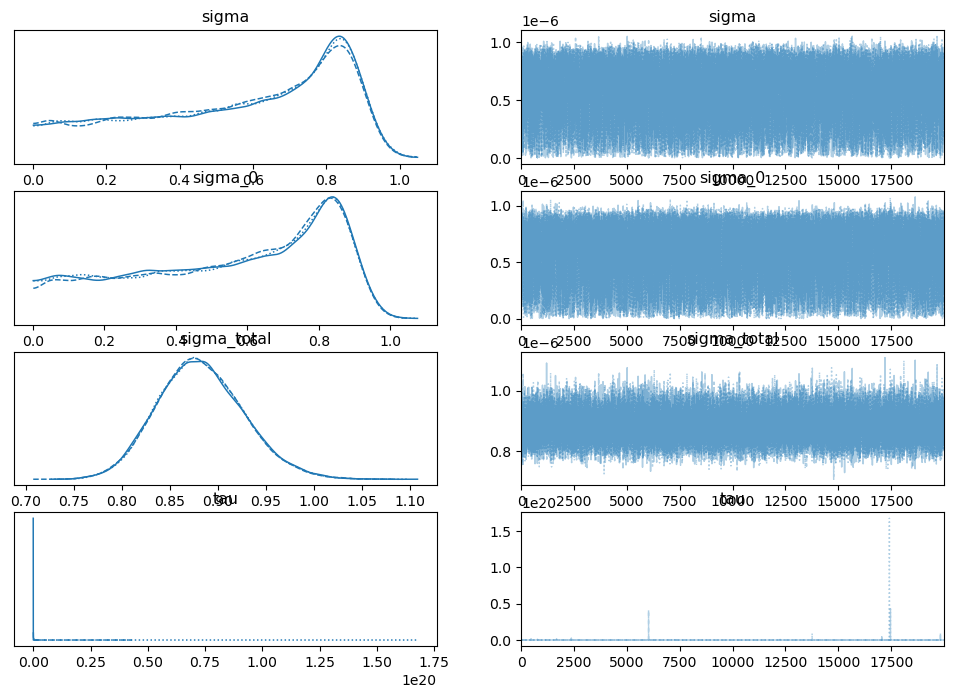

In [11]:
# Simulated data
# get x and y positions
index = 1
x_pos = positions[:, index, 0]
y_pos = positions[:, index, 1]

sigma_noise = 1e-8
x_pos = x_pos + np.random.normal(0, sigma_noise)
y_pos = y_pos + np.random.normal(0, sigma_noise)


true_radius = radii[index]
print(true_radius)

# calculate movement by differences between positions
x_dist = np.diff(x_pos)
y_dist = np.diff(y_pos)

dist_arr = np.concatenate((x_dist, y_dist))


# Define model
with pm.Model() as model:
    sigma = pm.HalfCauchy("sigma", beta=5)
    sigma_0 = pm.HalfCauchy("sigma_0", beta=1)  # small prior for noise
    
    sigma_total = pm.Deterministic("sigma_total", pm.math.sqrt(sigma**2 + sigma_0**2))
    tau = pm.Deterministic("tau", 1 / sigma**2)
    
    obs = pm.Normal("obs", mu=0, sigma=sigma_total, observed=dist_arr)
    
    # Use NUTS sampler
    trace = pm.sample(draws=20000, tune=10000, chains=3, target_accept=0.9, return_inferencedata=True)

# Summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

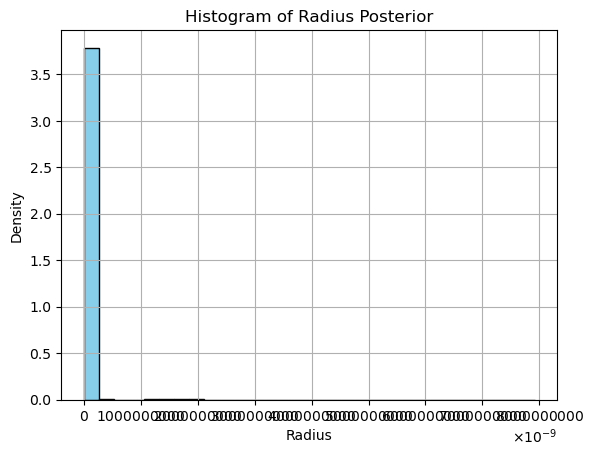

In [12]:
import matplotlib.pyplot as plt
import arviz as az

# Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()

# Multiply by C to get r
scaled_tau = tau_samples * C

# Plot histogram
plt.hist(scaled_tau, bins=30, density=True, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radius Posterior")
plt.grid(True)
plt.show()

In [13]:
np.mean(scaled_tau > true_radius)

np.float64(0.9150666666666667)

## Take Away

This section was a quick test to see if MCMC can distinguish between the diffusion variance and error variance

Clearly, it can't, which leads to terrible results, so we need to define and estimate for the error variance beforehand

# Incorporating errors in MCMC using defined errors from trackPy Demo

I'm using the stuff from TrackPy Demo run 39

Simulation with slight noise, constant brightness, and only 20 particles.

files are in 20_particles folder

Model description:

$$\tilde{x}_i = x_i + \epsilon \qquad \text{where} \qquad \epsilon \sim N(\mu_e, \sigma^2_e)$$

When can then say that for each observed distance:

$$\Delta\tilde{x}_i = \tilde x_i - \tilde x_{i - 1} = x_i + \epsilon - x_{i-1} - \epsilon = (x_i - x_{i-1}) + \epsilon  - \epsilon$$

When can describe its distribution as:

$$\Delta\tilde{x}_i \sim N(0, \sigma^2) +  N(\mu_e, \sigma^2_e) -  N(\mu_e, \sigma^2_e)$$

This can then be simplified as

$$\Delta\tilde{x}_i \sim N(0, \sigma^2 + 2 \sigma^2_e)$$

$$ $$

If we calculate and set $\sigma^2_e$, then we should be able to use MCMC to determine a posterior of $\sigma^2$





#### Load data and create tracks

In [14]:
with_noise = pims.open("20_particles/simulation_v3.tif")

noise_features = tp.batch(with_noise, diameter=15, minmass=1700, processes=1, characterize=True);

noise_tracks = tp.link(noise_features, search_range=10, memory=3)


Frame 99: 18 trajectories present.


#### export function from Main

In [15]:
def export_annotated_video(tracks, frames, output_path, numbers=True, fps=10, frame_num=True):
    # Make sure x, y are floats
    tracks['x'] = tracks['x'].astype(float)
    tracks['y'] = tracks['y'].astype(float)
    
    # Setup video writer
    frame_size = (frames.frame_shape[1], frames.frame_shape[0])  # width, height
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size, isColor=True)
    
    # Normalize function for 16-bit -> 8-bit grayscale
    def normalize_16bit_to_8bit(img):
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        return (img * 255).astype(np.uint8)
    
    # Loop through each frame
    for i, frame in enumerate(frames):
        img = normalize_16bit_to_8bit(frame)
    
        # Convert to BGR for drawing (required by OpenCV)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        if frame_num:
            cv2.putText(img_bgr, "frame: " + str(i), (20, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
        # Get particle positions in this frame
        particles = tracks[tracks['frame'] == i]

        if numbers == True:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                # Draw circle (ring-like)
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)
                # put number label
                cv2.putText(img_bgr, str(int(row['particle'])), (x+20, y+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        else:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                # Draw circle (ring-like)
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)
    
        # Write frame
        writer.write(img_bgr)
    
    writer.release()
    print(f"Saved to {output_path}")

#### Call export function

Make list of numbers with perfect tracks

In [16]:
export_annotated_video(noise_tracks, with_noise, "20_particle_annotated.mp4", numbers=True, fps=10, frame_num=True)

Saved to 20_particle_annotated.mp4


In [17]:
# one to start with for now
# doing number 11 down below

### Simulation and Inference parameters

In [18]:
ground = pd.read_csv("20_particles/simulation_v3_tracks.csv")

credible_percentage = 0.95

# sim settings
t =  0.033
T_Kelvin = 296.55
eta = 9.2e-4
k_B = 1.38e-23
pixel_size = 3.149e-07

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)

# convert trackPy estimates to meters
tp_converted = noise_tracks.copy()
tp_converted['x'] = tp_converted['x'] * pixel_size
tp_converted['y'] = tp_converted['y'] * pixel_size


#### Get Track and Ground info

In [19]:
tp_particle_num = 11

tp_track = tp_converted[tp_converted['particle'] == tp_particle_num]

tp_track_0 = tp_track[tp_track['frame'] == 0]
tp_x = tp_track_0['x'].item()
tp_y = tp_track_0['y'].item()

gnd_frame_0 = ground[ground['frame'] == 0]

# determine ground truth num based on first frame
distances = np.sqrt((gnd_frame_0['x'] - tp_x)**2 + (gnd_frame_0['y'] - tp_y)**2)
closest_ind = np.argmin(distances)
gnd_num = gnd_frame_0.iloc[closest_ind]['particle']

# get ground truth radius:
true_radius = gnd_frame_0[gnd_frame_0['particle'] == gnd_num]['size'].item()


#### Determine estimation errors

In [20]:
gnd_track = ground[ground['particle'] == gnd_num]

x_errors = tp_track['x'].values - gnd_track['x'].values
y_errors = tp_track['y'].values - gnd_track['y'].values

errors = np.concatenate((x_errors, y_errors))

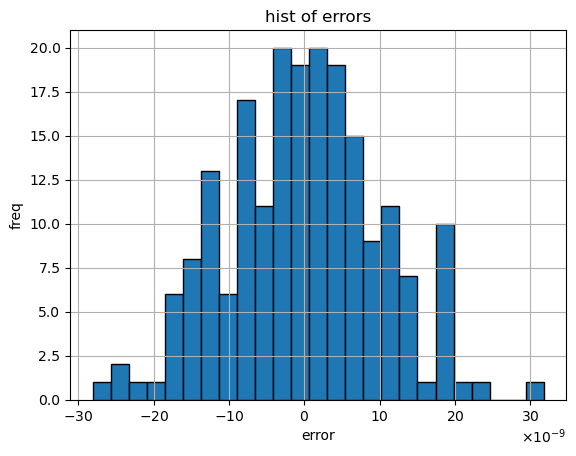

In [21]:
plt.hist(errors, bins=25, edgecolor='black')
plt.title("hist of errors")
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("error")
plt.ylabel("freq")
plt.grid(True)
plt.show()

In [22]:
from scipy.stats import norm

mu_error, sigma_error = norm.fit(errors)


In [23]:
mu_error

np.float64(-9.434378290904411e-11)

### Run MCMC model

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma2]


Output()

Sampling 3 chains for 10_000 tune and 20_000 draw iterations (30_000 + 60_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


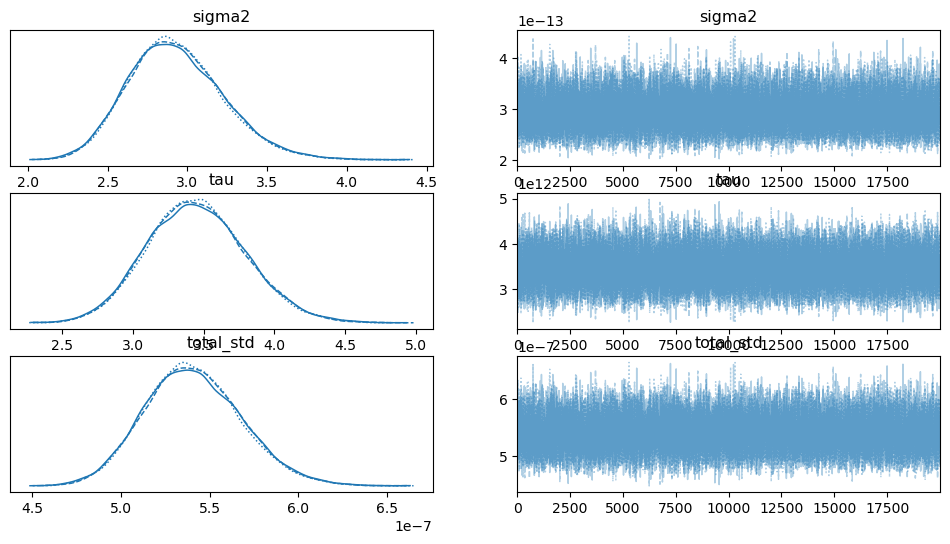

In [24]:
x_pos = tp_track['x'].to_numpy()
y_pos = tp_track['y'].to_numpy()

# calculate movement by differences between positions
x_dist = np.diff(x_pos)
y_dist = np.diff(y_pos)

dists = np.concatenate((x_dist, y_dist))

sigma_e2 = sigma_error**2

# PyMC model
with pm.Model() as model:
    # Prior for process variance sigma^2 (can adjust based on domain knowledge)
    sigma2 = pm.HalfCauchy("sigma2", beta=2)
    
    tau = pm.Deterministic("tau", 1 / sigma2)
    
    # Total standard deviation of observed deltas
    total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

    # Likelihood
    obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

    # Run MCMC with NUTS
    trace = pm.sample(draws=20000, tune=10000, chains=3, target_accept=0.9, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

4.7897862718780835e-08


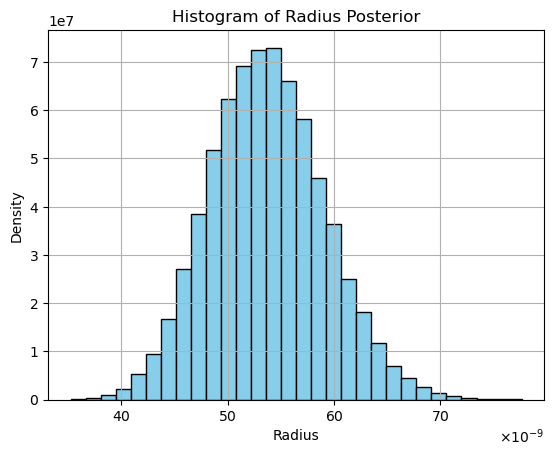

In [25]:
print(true_radius)

import matplotlib.pyplot as plt
import arviz as az

# Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()

# Multiply by C to get r
scaled_tau = tau_samples * C

# Plot histogram
plt.hist(scaled_tau, bins=30, density=True, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radius Posterior")
plt.grid(True)
plt.show()

In [26]:
np.mean(scaled_tau > true_radius)

np.float64(0.8605333333333334)

## Take Away

The section above was used to demonstrate that we could define an error variance and run MCMC inference.

We then quanitfy the effect and accruacy/coverage of this in MCMC Monte Carlo test notebook